# Comparing overturning circulation in ACCESS-OM3 with ACCESS-OM2

This notebook uses the initial spinup simulation of ACCESS-OM3.

In [ ]:
#parameters

### USER EDIT start
# esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
esm_file='/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.dpi']= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json
Plot folder path:  /g/data/tm70/cyb561/access-om3-paper-1/notebooks/mkfigs_output/2/


In [2]:
import intake
from dask.distributed import Client
import matplotlib.pyplot as plt
import cmocean as cm
import cftime

In [3]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/proxy/8787/status


## Load ACCESS-OM3 data from ESM datastore

In [4]:
exptname=os.path.basename(os.path.dirname(esm_file))

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=[
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
    ]
)

In [5]:
exptname

'25km-iaf-test-for-AK-expt-7df5ef4c'

In [6]:
vmo_all = datastore.search(variable="vmo").to_dask(
    xarray_open_kwargs = dict(
        chunks={"time": -1},
        decode_timedelta=True
    )
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [7]:
##### ONLY NEEDED FOR 25km-iaf-test-for-AK-expt-7df5ef4c !!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# omit latitudes with grid bug https://github.com/ACCESS-NRI/ocean_model_grid_generator/issues/7
vmo_all = vmo_all.isel(yq=slice(10, None))

In [8]:
# omit tripolar region https://github.com/COSIMA/cosima-recipes/issues/510
vmo_all = vmo_all.sel(yq=slice(None, 65))

In [9]:
# for IAF
vmo_all = vmo_all.convert_calendar("proleptic_gregorian", use_cftime=True)

In [10]:
vmo_all.time.values[0] # initial date in data

cftime.DatetimeProlepticGregorian(1958, 1, 16, 12, 0, 0, 0, has_year_zero=True)

In [11]:
vmo_all.time.values[-1] # final date in data

cftime.DatetimeProlepticGregorian(2023, 12, 16, 12, 0, 0, 0, has_year_zero=True)

In [12]:
# set time range

# timerange = slice(cftime.DatetimeNoLeap(1942, 1, 1, 0, 0, 0, 0),
#                   cftime.DatetimeNoLeap(1952, 1, 1, 0, 0, 0, 0))
# timerange = slice(None, None)
# datestop = vmo_all.time.values[-1] # final date in data
datestop = cftime.DatetimeProlepticGregorian(2018, 12, 14, 12, 0, 0, 0, has_year_zero=True)  # to match OM2 IAF run
datelist = list(cftime.to_tuple(datestop))
datelist[0] -= 10  # last 10 years
datestart = cftime.datetime(*datelist, calendar=datestop.calendar)
timerange = slice(datestart, datestop)

In [13]:
datestart

cftime.datetime(2008, 12, 14, 12, 0, 0, 0, calendar='proleptic_gregorian', has_year_zero=True)

In [14]:
datestop

cftime.DatetimeProlepticGregorian(2018, 12, 14, 12, 0, 0, 0, has_year_zero=True)

In [15]:
vmo_subset = vmo_all.sel(time=timerange)

### Load and plot data from ACCESS-OM2
use control - see https://forum.access-hive.org.au/t/access-om2-control-experiments/258#p-747-ryf-7

In [16]:
# RYF
# om2exptname = '025deg_jra55_ryf9091_gadi' # Note that this simulation doesn't have the GM component of the overturning as a diagnostic - it has GM switched on, but not diagnosed.
# frequency='1yr' # for 025deg_jra55_ryf9091_gadi

# IAF
om2exptname = '025deg_jra55_iaf_omip2_cycle1'
frequency = '1mon'

datastore = intake.cat.access_nri[om2exptname]

In [17]:
ty_trans_rho_all = datastore.search(
                        variable='ty_trans_rho',
                        frequency=frequency
                        ).to_dask(
                                    xarray_open_kwargs=dict(
                                    chunks={"time": -1},
                                    decode_timedelta=True,
                                    use_cftime=True)
                                )

try:  # add gm transport if available
    ty_trans_rho_all += datastore.search(
                        variable='ty_trans_rho_gm',
                        frequency=frequency
                        ).to_dask(
                                    xarray_open_kwargs=dict(
                                    chunks={"time": -1},
                                    decode_timedelta=True,
                                    use_cftime=True)
                                )
    gm_included = True
except ValueError:
    gm_included = False
    print('Warning: ty_trans_rho_gm not found!')

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.08/lib/python3.11/site-packages/intake_esm/core.py:301: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [18]:
# omit tripolar region https://github.com/COSIMA/cosima-recipes/issues/510
ty_trans_rho_all = ty_trans_rho_all.sel(grid_yu_ocean=slice(None, 65))

In [19]:
# for IAF
ty_trans_rho_all = ty_trans_rho_all.convert_calendar("proleptic_gregorian", use_cftime=True)

In [20]:
ty_trans_rho_subset = ty_trans_rho_all.sel(time=timerange)

## 10-year mean overturning streamfunction

In [21]:
rho0 = 1035 # reference density for both OM2 and OM3

In [22]:
%%time
psi_OM3 = (
    vmo_subset["vmo"]
    .mean("time")
    .sum("xh")
    .cumsum("rho2_l")
    .load()
    / rho0
    / 1e6
)

CPU times: user 6.53 s, sys: 1.3 s, total: 7.83 s
Wall time: 36.6 s


In [23]:
%%time
psi_OM2 = (
    ty_trans_rho_subset["ty_trans_rho"]
    .mean("time")
    .sum("grid_xt_ocean")
    .cumsum("potrho")
    .load()
    / rho0
    / 1e6
)

CPU times: user 10.6 s, sys: 1.54 s, total: 12.1 s
Wall time: 39.5 s


Text(0.5, 1.0, 'ACCESS-OM3 overturning 2008-12-16 - 2018-11-16 mean in 25km-iaf-test-for-AK-expt-7df5ef4c')

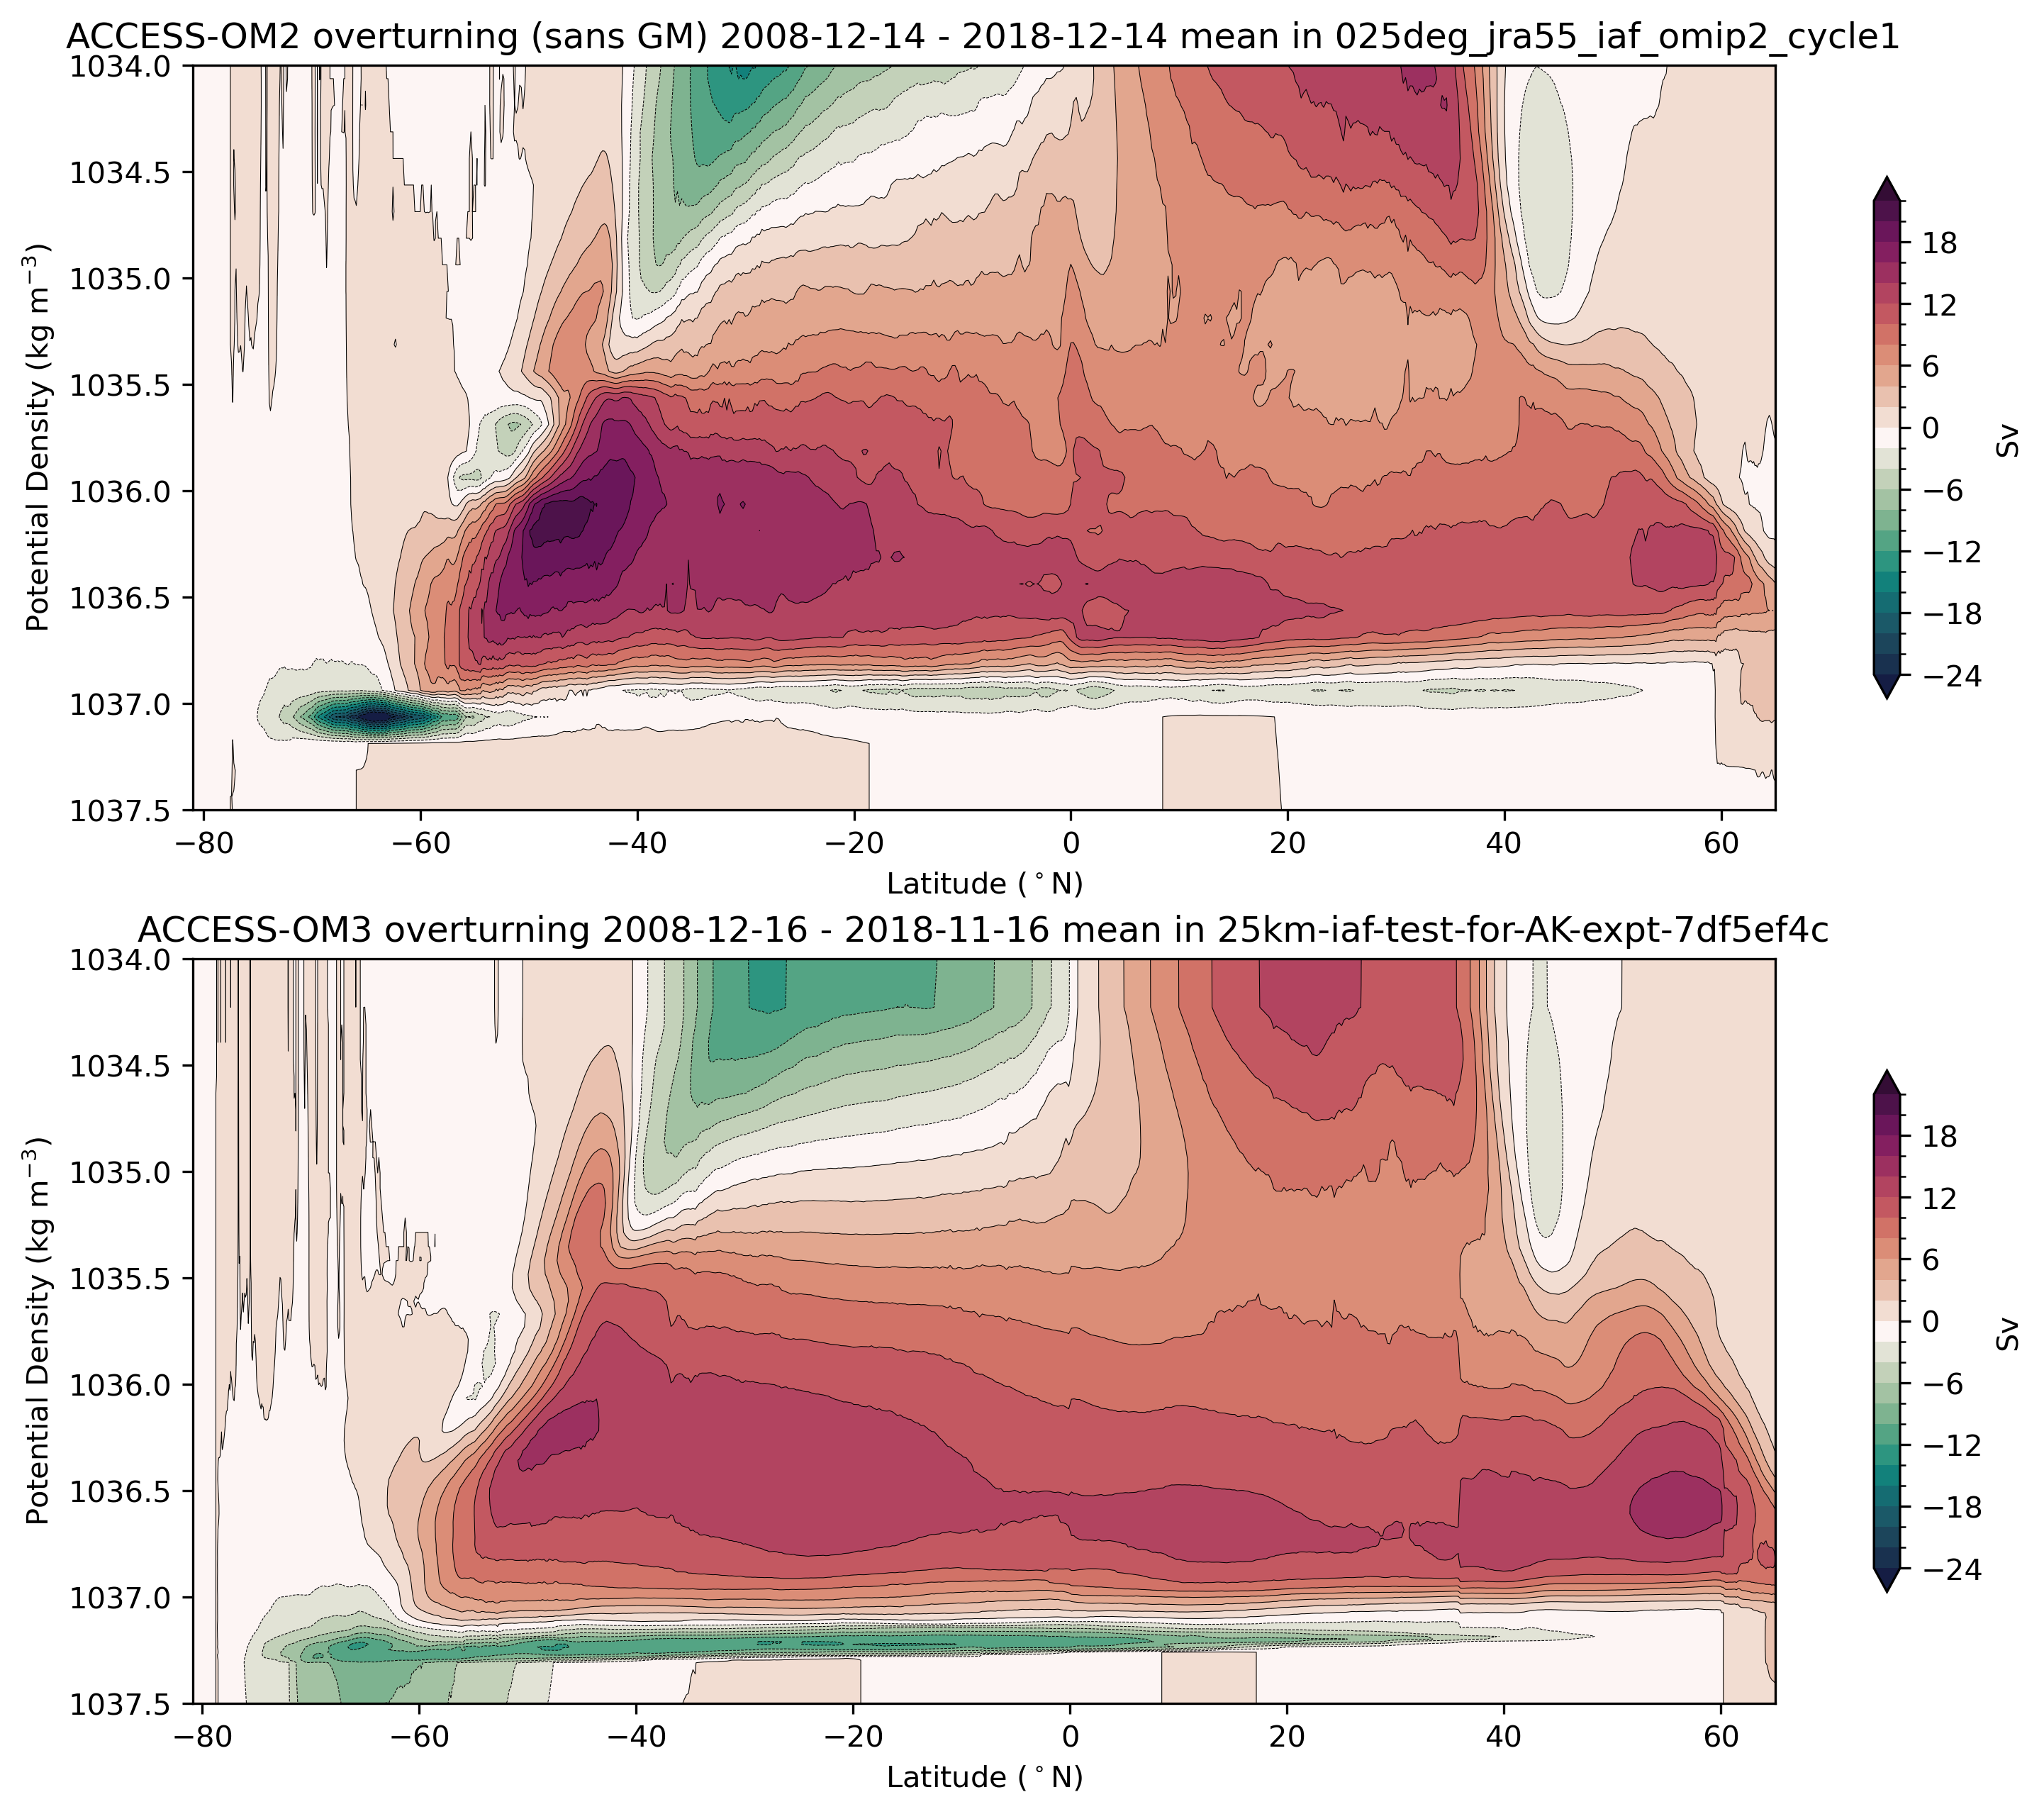

In [24]:
plt.figure(figsize=(12, 10))
levels = range(-24, 24, 2)
plt.subplot(211)
psi_OM2.plot.contourf(
    levels=levels, cmap=cm.cm.curl, extend="both",
    cbar_kwargs={"label": "Sv", "shrink": 0.7}
)
psi_OM2.plot.contour(levels=levels, colors="k", linewidths=0.25)
plt.gca().invert_yaxis()
plt.ylim((1037.5, 1034))
plt.ylabel("Potential Density (kg m$^{-3}$)")
plt.xlabel("Latitude ($^\circ$N)")
if gm_included:
    plt.title(f"ACCESS-OM2 overturning {ty_trans_rho_subset.time.values[0].strftime('%Y-%m-%d')} - {ty_trans_rho_subset.time.values[-1].strftime('%Y-%m-%d')} mean in {om2exptname}")
else:
    plt.title(f"ACCESS-OM2 overturning (sans GM) {ty_trans_rho_subset.time.values[0].strftime('%Y-%m-%d')} - {ty_trans_rho_subset.time.values[-1].strftime('%Y-%m-%d')} mean in {om2exptname}")

plt.subplot(212)
psi_OM3.plot.contourf(
    levels=levels, cmap=cm.cm.curl, extend="both",
    cbar_kwargs={"label": "Sv", "shrink": 0.7}
)
psi_OM3.plot.contour(levels=levels, colors="k", linewidths=0.25)
plt.gca().invert_yaxis()
plt.ylim((1037.5, 1034))
plt.ylabel("Potential Density (kg m$^{-3}$)")
plt.xlabel("Latitude ($^\circ$N)")
plt.title(f"ACCESS-OM3 overturning {vmo_subset.time.values[0].strftime('%Y-%m-%d')} - {vmo_subset.time.values[-1].strftime('%Y-%m-%d')} mean in {exptname}")

## Timeseries of overturning at key latitudes

In [25]:
%%time
psi_time_OM3 = vmo_all["vmo"].sum("xh").cumsum("rho2_l") / rho0 / 1e6
psi_30S_OM3 = (
    psi_time_OM3.sel(yq=-30, method="nearest")
    .sel(rho2_l=slice(1035, 1038))
    .max(dim="rho2_l")
    .resample(time = '1YE').mean('time')
    .load()
)
psi_26N_OM3 = (
    psi_time_OM3.sel(yq=26, method="nearest")
    .sel(rho2_l=slice(1035, 1038))
    .max(dim="rho2_l")
    .resample(time = '1YE').mean('time')
    .load()
)
psi_55N_OM3 = (
    psi_time_OM3.sel(yq=5, method="nearest")
    .sel(rho2_l=slice(1035, 1038))
    .max(dim="rho2_l")
    .resample(time = '1YE').mean('time')
    .load()
)
psi_abyss_OM3 = (
    -psi_time_OM3.sel(yq=-40, method="nearest")
    .sel(rho2_l=slice(1035, 1038))
    .min(dim="rho2_l")
    .resample(time = '1YE').mean('time')
    .load()
)

CPU times: user 31 s, sys: 5.11 s, total: 36.1 s
Wall time: 2min 14s


In [26]:
%%time
psi_time_OM2 = ty_trans_rho_all["ty_trans_rho"].sum("grid_xt_ocean").cumsum("potrho") / rho0 / 1e6
psi_30S_OM2 = (
    psi_time_OM2
    # .sel(time=slice("1900-01-01", "1949-12-31"))
    .sel(grid_yu_ocean=-30, method="nearest")
    .sel(potrho=slice(1035, 1038))
    .max(dim="potrho")
    .resample(time = '1YE').mean('time')
    .load()
)
psi_26N_OM2 = (
    psi_time_OM2
    # .sel(time=slice("1900-01-01", "1949-12-31"))
    .sel(grid_yu_ocean=26, method="nearest")
    .sel(potrho=slice(1035, 1038))
    .max(dim="potrho")
    .resample(time = '1YE').mean('time')
    .load()
)
psi_55N_OM2 = (
    psi_time_OM2
    # .sel(time=slice("1900-01-01", "1949-12-31"))
    .sel(grid_yu_ocean=55, method="nearest")
    .sel(potrho=slice(1035, 1038))
    .max(dim="potrho")
    .resample(time = '1YE').mean('time')
    .load()
)
psi_abyss_OM2 = (
    -psi_time_OM2
    # .sel(time=slice("1900-01-01", "1949-12-31"))
    .sel(grid_yu_ocean=-40, method="nearest")
    .sel(potrho=slice(1035, 1038))
    .min(dim="potrho")
    .resample(time = '1YE').mean('time')
    .load()
)

CPU times: user 44.3 s, sys: 4.14 s, total: 48.4 s
Wall time: 1min 38s


Text(0, 0.5, '')

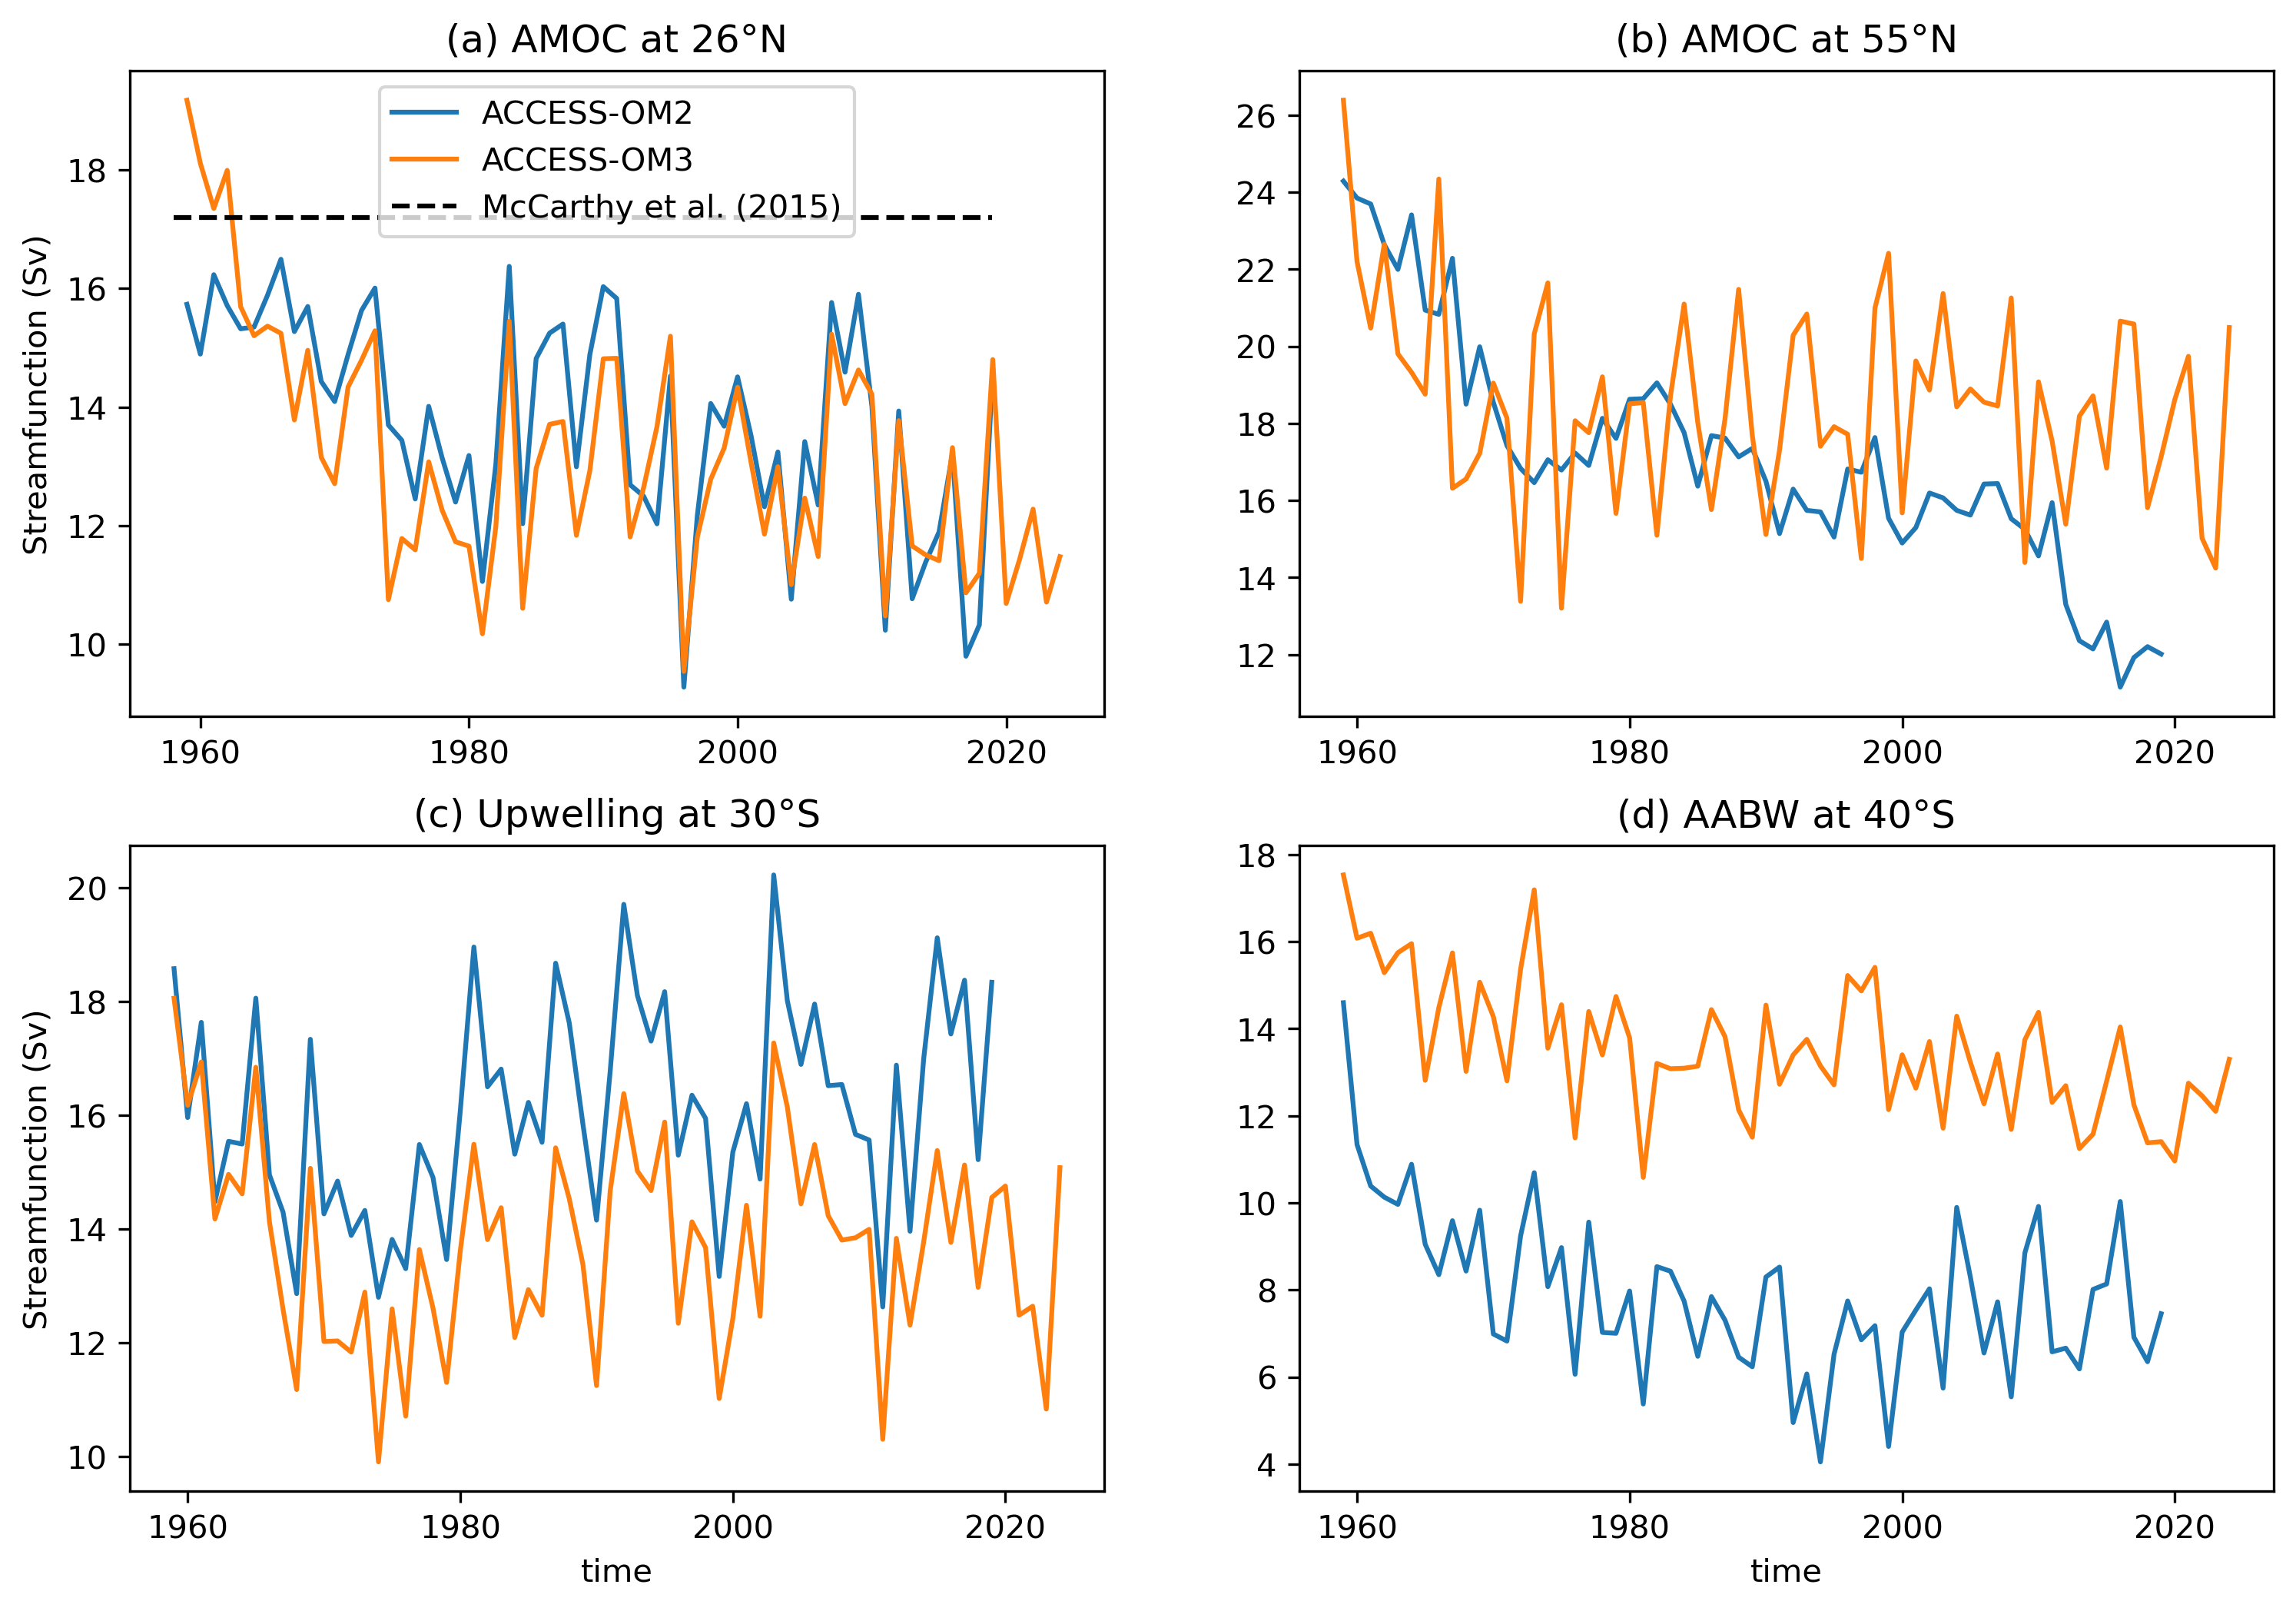

In [27]:
plt.figure(figsize=(12, 8)) 

plt.subplot(221)
psi_26N_OM2.plot(label='ACCESS-OM2')
psi_26N_OM3.plot(label='ACCESS-OM3')
plt.plot([ty_trans_rho_all.time.values[0], ty_trans_rho_all.time.values[-1]], [17.2, 17.2],
           'k--', label="McCarthy et al. (2015)")
# plt.plot([cftime.datetime(1900, 1, 1), cftime.datetime(1950, 12, 31)], [17.2, 17.2],
#            'k--', label="McCarthy et al. (2015)")
plt.title('(a) AMOC at 26°N')
plt.ylabel('Streamfunction (Sv)')
plt.legend()
plt.xlabel('')

plt.subplot(222)
psi_55N_OM2.plot()
psi_55N_OM3.plot()
plt.title('(b) AMOC at 55°N')
plt.ylabel('')
plt.xlabel('')

plt.subplot(223)
psi_30S_OM2.plot()
psi_30S_OM3.plot()
plt.title('(c) Upwelling at 30°S')
plt.ylabel('Streamfunction (Sv)')

plt.subplot(224)
psi_abyss_OM2.plot()
psi_abyss_OM3.plot()
plt.title('(d) AABW at 40°S')
plt.ylabel('')


In [28]:
client.close()